In [14]:
import pickle
import pandas as pd
import numpy as np
from torch_geometric.data import Data, DataLoader
import model
import torch
from sklearn.metrics import f1_score
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

In [15]:
with open('masking.pkl', 'rb') as f:
    masking = pickle.load(f)

In [16]:
masking.shape

(128150,)

In [17]:
masking.max()

0.940583

In [18]:
masking.min()

0.0

In [19]:
masking.mean()

3.0063837e-05

In [7]:
masking

array([0.07227281, 0.07227281, 0.07227281, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [8]:
torch.tensor([3]).to('cuda')

tensor([3], device='cuda:0')

In [2]:
class LayerActivations():
    features=None
    
    def __init__(self,model):
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu()
    
    def remove(self):
        self.hook.remove()
        
class SAGPoolLayerActivations():
    features=None
    
    def __init__(self,model):
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output
    
    def remove(self):
        self.hook.remove()

In [3]:
def softmax(a) :
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a,axis=1)
    y = (exp_a.T / sum_exp_a).T
    return y

### Load Model

In [4]:
num_genes = 9630
num_class = 5
num_layers = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#model = model.simpleGCN(num_genes,num_class,num_layers=num_layers).to(device)
model = model.simpleGCN_SAGPOOL(num_genes,num_class,num_layers=num_layers).to(device)


save_path = "./data/model/simpleGCN_SAGPOOL_layer2/model_epoch800"

simpleGCN_SAGPOOL:2 layers
cuda


In [5]:
model.load_state_dict(torch.load(save_path))
#model.eval()

<All keys matched successfully>

### Load Dataset

In [9]:
f = open("./data/preprocessed/cv/tcga_brca_dataset_test_0.pkl",'rb')
test_list = pickle.load(f)
batch_size = len(test_list)
f.close()
test_loader = DataLoader(test_list, batch_size=batch_size)

### Test

In [6]:
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.to(device))
        pred = out.max(dim=1)[1]
        preds.append(pred.cpu())
    
    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='weighted') if pred.sum() > 0 else 0

In [7]:
test_f1 = test(test_loader)
print('test: {:.4f}'.format(test_f1))

ys = []
for data in test_loader:
    ys.extend(data.y.numpy())

test: 0.8459


In [10]:
ys = []
for data in test_loader:
    ys.extend(data.y.numpy())

In [ ]:
# final output 
# model_out = LayerActivations(model.lin1,0)
# o = model(data.to(device))
# model_out.remove()
# act = model_out.features
# act = pd.DataFrame(act.detach().numpy())
# act = softmax(act)

#conv output
model_out = LayerActivations(model.convs[0])
o = model(data.to(device))
model_out.remove()
act = model_out.features
act = pd.DataFrame(act.detach().numpy())
# act = softmax(act)

In [249]:
num_node = int(act.shape[0] / batch_size)
for batch in range(batch_size):
    batch_act = act.loc[batch*num_node: ((batch*num_node)+num_node)-1,:]

In [250]:
batch_act

,0,1,2,3,4
1165230,6.278998,-7.557869,7.898623,8.426652,-15.263873
1165231,-16.017271,19.208015,-20.050964,-11.197689,16.618876
1165232,12.437840,-14.980095,15.657197,8.828649,-9.022800
1165233,-1.350782,1.586459,-1.645604,12.541518,-37.890507
1165234,35.922203,-43.295429,45.256771,31.446445,-54.803997
...,...,...,...,...,...
1174855,4.699512,-5.685922,5.949687,2.299675,2.208913
1174856,-4.256168,5.073518,-5.287891,1.701936,-6.460974
1174857,-2.188169,2.579397,-2.679738,0.710964,-3.137712
1174858,0.778098,-0.953371,1.001744,6.622253,-16.070740


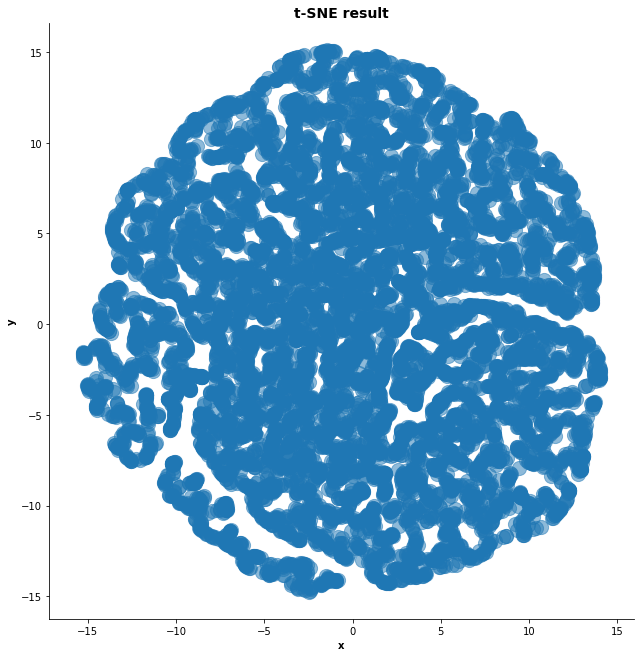

In [252]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_ref = tsne.fit_transform(batch_act)
tsne_ref_df = pd.DataFrame(tsne_ref,columns=['x','y'])
# tsne_ref_df['Label'] = ys[:]
sns.lmplot(x="x", y="y", data=tsne_ref_df, fit_reg=False, legend=True, size=9,scatter_kws={"s":200, "alpha":0.5})
plt.title('t-SNE result', weight='bold').set_fontsize('14')
plt.xlabel('x', weight='bold').set_fontsize('10')
plt.ylabel('y', weight='bold').set_fontsize('10')
plt.show()

### graph representation t-sne

In [176]:
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)

In [193]:
tsne_ref = tsne.fit_transform(act)
tsne_ref_df = pd.DataFrame(tsne_ref,columns=['x','y'])
tsne_ref_df['Label'] = ys[:]

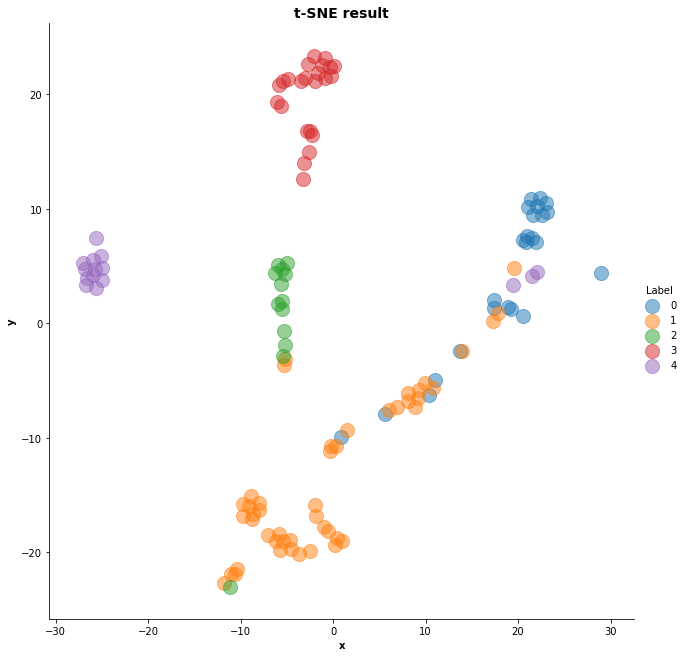

In [197]:
sns.lmplot(x="x", y="y", data=tsne_ref_df, fit_reg=False, legend=True, size=9, hue='Label', scatter_kws={"s":200, "alpha":0.5})
plt.title('t-SNE result', weight='bold').set_fontsize('14')
plt.xlabel('x', weight='bold').set_fontsize('10')
plt.ylabel('y', weight='bold').set_fontsize('10')
plt.show()

### Pooling Analysis

In [11]:
model_out = SAGPoolLayerActivations(model.pool1)
o = model(data.to(device))
model_out.remove()
act = model_out.features
#act = pd.DataFrame(act.detach().numpy())

In [27]:
x,edge_index,_,batch,_  = act

In [31]:
edge_index = edge_index.T

In [39]:
edge_index

tensor([[   211,    856],
        [   211,   2082],
        [   211,   1303],
        ...,
        [583651, 582618],
        [583715, 582925],
        [586960, 582925]], device='cuda:0')

In [38]:
edge_index[0:2,:]

tensor([[ 211,  856],
        [ 211, 2082]], device='cuda:0')

In [45]:
mask = (batch==0)

In [50]:
len(mask)

587430

In [51]:
edge_index[mask]

IndexError: The shape of the mask [587430] at index 0 does not match the shape of the indexed tensor [15148127, 2] at index 0